In [1]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

In [2]:
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import argparse
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# Set random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disables fast auto-tuning


# Time tracking decorator
def time_tracker(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        print(f"Starting {func.__name__}...")
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} took {end_time - start_time:.2f} seconds to execute.")
        return result
    return wrapper

# Split data into training, validation, and test sets
@time_tracker
def sample_data(numerical_data_filtered, labels_encoded, split_size, random_state=42):
    if split_size == 'shuffled_10000':
        return generate_shuffled_data(numerical_data_filtered, 10000, random_state)
    else:
        size = int(split_size)
        if size < len(numerical_data_filtered):
            print(f"Splitting data with size: {size}")
            splitter = StratifiedShuffleSplit(n_splits=1, train_size=size, random_state=random_state)
            for train_idx, _ in splitter.split(numerical_data_filtered, labels_encoded):
                return numerical_data_filtered.iloc[train_idx], [labels_encoded[i] for i in train_idx]
        else:
            return numerical_data_filtered, labels_encoded


@time_tracker
def train_val_test_split(data, labels, random_state=42):
    print("Splitting data into training, validation, and test sets...")
    
    # Convert labels list to pandas Series to use value_counts()
    import pandas as pd
    labels_series = pd.Series(labels, index=data.index)
    
    # Filter labels to exclude classes with fewer than 20 samples
    label_counts = labels_series.value_counts()
    valid_labels = label_counts[label_counts > 20].index

    # Select only data and labels corresponding to classes with more than 20 samples
    valid_indices = labels_series.isin(valid_labels)
    data_filtered = data.loc[valid_indices]
    labels_filtered = labels_series.loc[valid_indices]

    # Perform the split with stratification on filtered data
    from sklearn.model_selection import train_test_split

    X_train, X_remaining, y_train, y_remaining = train_test_split(
        data_filtered, labels_filtered, test_size=0.3, random_state=random_state, stratify=labels_filtered
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_remaining, y_remaining, test_size=0.4, random_state=random_state, stratify=y_remaining
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test



@time_tracker
def scale_and_save_data(train_val_test_splits, output_path, split_data_value=10000):
    scaler = StandardScaler()
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_splits
    print(f"Scaling and saving data...")
    
    # Scaling the features
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_val_scaled = scaler.transform(X_val)
    # X_test_scaled = scaler.transform(X_test)
    
    # Converting to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

    # Convert labels to numpy arrays before converting to tensors
    y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

    # Creating TensorDataset objects
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create output directory if it does not exist
    dataset_path = f'{output_path}/{split_data_value}/'
    directory_path = Path(dataset_path)
    directory_path.mkdir(parents=True, exist_ok=True)

    # Save the datasets
    torch.save(train_dataset.tensors, f'{dataset_path}train_dataset_tensors.pt')
    torch.save(val_dataset.tensors, f'{dataset_path}val_dataset_tensors.pt')
    torch.save(test_dataset.tensors, f'{dataset_path}test_dataset_tensors.pt')
    print(f"Data saved successfully.")





In [ ]:


set_seed(42)


# Load or prepare data
numerical_data_path = 'data/v2/numerical_data_filtered.csv'
metadata_path = 'data/v2/metadata_with_labels.csv'

print("Checking if preprocessed data exists...")

print("Preprocessed data not found. Loading raw data and processing...")
data_files = [f'../data/v2_HM450/methyl_scores_v2_HM450k_{i}.pkl' for i in range(1, 12)]
dataframes = [pd.read_pickle(file, compression="bz2") for file in data_files]
df = pd.concat(dataframes, axis=0)

metadata_columns = [
    'id', 'geo_accession', 'title', 'sex', 'age', 'race', 'tissue',
    'geo_platform', 'inferred_age_Hannum', 'inferred_age_SkinBlood',
    'inferred_age_Horvath353'
]
label_column = 'disease'
sex_condition_column = 'inferred_sex'
age_condition_column = 'inferred_age_MepiClock'

numerical_data = df.drop(
    metadata_columns + [label_column, sex_condition_column, age_condition_column],
    axis=1
)

# Fix FutureWarning
df[label_column] = df[label_column].fillna('no_label')

# Fix PerformanceWarning
labels_encoded = df[label_column].astype('category').cat.codes
df = pd.concat([df, labels_encoded.rename('labels_encoded')], axis=1)
df = df.reset_index()

nan_percentage = numerical_data.isna().sum() / numerical_data.shape[0] * 100
selected_columns = nan_percentage[nan_percentage < 10].index.tolist()
numerical_data_filtered = numerical_data[selected_columns]
print("Data is processed successfully.")



Checking if preprocessed data exists...
Preprocessed data not found. Loading raw data and processing...


In [14]:
column_variances = numerical_data_filtered.var()


In [15]:
sorted_variances = column_variances.sort_values(ascending=False)


In [19]:
import matplotlib.pyplot as plt


# Select the top N columns
top_n = 20000  # adjust as needed
top_variances = sorted_variances.head(top_n)

# Plot
plt.figure(figsize=(10, 6))
top_variances.plot(kind='bar')
plt.title(f'Top {top_n} Columns by Variance')
plt.xlabel('Columns')
plt.ylabel('Variance')
plt.show()



KeyboardInterrupt



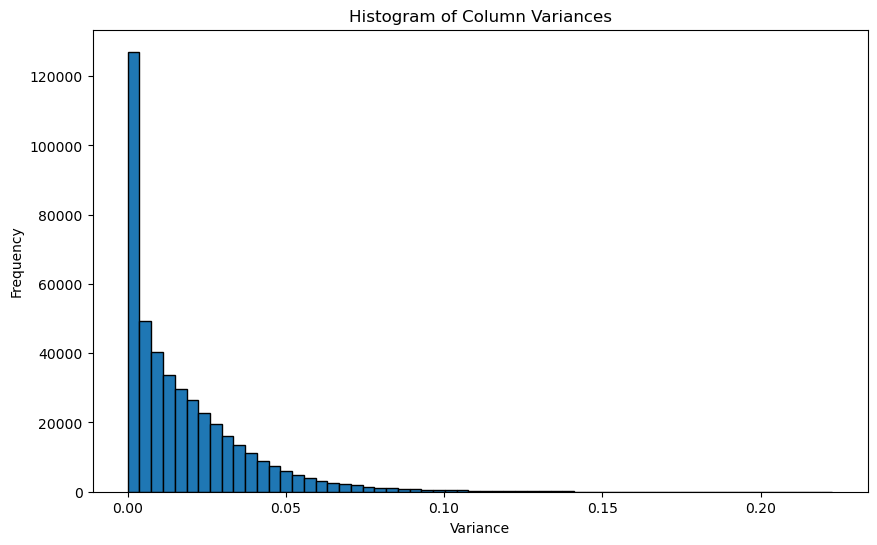

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(column_variances, bins=60, edgecolor='k')
plt.title('Histogram of Column Variances')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()


In [24]:
print((column_variances> 0.05).sum())
print((column_variances> 0.1).sum())

30442
2596


In [37]:
print(column_variances.max())
print(column_variances.median())
print(column_variances.min())


0.2227
0.0115
6.884e-05


In [ ]:
numerical_data_filtered[column_variances.index[(column_variances>0.1)]].to_csv('../data/dimension_reduction/highly_variable_features/numerical_data_filtered_0_10.csv')
numerical_data_filtered[column_variances.index[(column_variances>0.05)]].to_csv('../data/dimension_reduction/highly_variable_features/numerical_data_filtered_0_05.csv')
metadata_columns_with_labels = metadata_columns + [label_column, sex_condition_column, age_condition_column, 'labels_encoded']
df_metadata = df[metadata_columns_with_labels]
df_metadata.to_csv('../data/dimension_reduction/highly_variable_features/metadata_with_labels.csv')

In [33]:
numerical_data_filtered[column_variances.index[(column_variances>0.1)]]

/fast/AG_Ohler/ekarimi/miniforge/envs/meth/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/fast/AG_Ohler/ekarimi/miniforge/envs/meth/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,cg00011616,cg00015530,cg00017461,cg00025044,cg00025496,cg00032912,cg00035969,cg00041401,cg00041575,cg00041666,...,rs5931272,rs6546473,rs7660805,rs7746156,rs798149,rs877309,rs9292570,rs9363764,rs939290,rs951295
GSM2947470,0.394043,0.937988,0.578613,0.797852,0.036255,0.633789,0.746582,0.830566,0.895996,0.143555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2947471,0.438721,0.897949,0.614258,0.731934,0.045563,0.640625,0.791016,0.897461,0.897461,0.125244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2947472,0.398926,0.928223,0.555664,0.820312,0.042694,0.630371,0.722656,0.819824,0.865234,0.167480,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2947473,0.373291,0.878906,0.606934,0.793457,0.040649,0.612305,0.747559,0.782227,0.884766,0.175781,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2947474,0.699219,0.852051,0.590820,0.833008,0.064209,0.458740,0.745117,0.785645,0.846191,0.169556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM4565216,0.549316,0.978027,0.951172,0.959473,0.958496,0.980469,0.686035,0.074524,0.368896,0.031952,...,0.979980,0.518066,0.689941,0.979980,0.982910,0.546387,0.514160,0.970215,0.525879,0.210815
GSM4565217,0.492676,0.970215,0.969727,0.966797,0.958984,0.980957,0.703125,0.045166,0.354248,0.029083,...,0.980957,0.541016,0.711426,0.979980,0.984375,0.556152,0.490723,0.966797,0.523438,0.193726
GSM4565218,0.445312,0.978516,0.961914,0.967285,0.958008,0.976074,0.715820,0.070923,0.320801,0.027283,...,0.981934,0.579102,0.681641,0.979980,0.985840,0.579102,0.496826,0.964844,0.582520,0.190918
GSM4565219,0.472168,0.974609,0.958008,0.964844,0.946289,0.978516,0.688477,0.081909,0.350098,0.039124,...,0.982422,0.568359,0.730957,0.982422,0.983398,0.588379,0.509766,0.969727,0.580078,0.223755


In [ ]:

# # Save a subset of the numerical data filtered (first 20000 columns)
numerical_data_filtered_subset = numerical_data_filtered.iloc[:, :20000]
numerical_data_filtered_subset.to_csv('data/v2/numerical_data_filtered_subset.csv')
# numerical_data_filtered.to_csv(numerical_data_path)
metadata_columns_with_labels = metadata_columns + [label_column, sex_condition_column, age_condition_column, 'labels_encoded']
df_metadata = df[metadata_columns_with_labels]
df_metadata.to_csv(metadata_path)
# print("Data saved successfully, including subset of first 20000 columns.")

# numerical_data_filtered.to_csv(numerical_data_path, index=False)
# metadata_columns_with_labels = metadata_columns + [label_column, sex_condition_column, age_condition_column, 'labels_encoded']
# df_metadata = df[metadata_columns_with_labels]
# df_metadata.to_csv(metadata_path, index=False)
# print("Data saved successfully.")

In [3]:
# set_seed(42)


# Load or prepare data
numerical_data_path = 'data/v2/numerical_data_filtered_subset.csv'
metadata_path = 'data/v2/metadata_with_labels.csv'

print("Checking if preprocessed data exists...")

print("Loading preprocessed data from CSV files...")
numerical_data_filtered = pd.read_csv(numerical_data_path,  low_memory=False, index_col=0)
df_metadata = pd.read_csv(metadata_path,  low_memory=False, index_col=0)


Checking if preprocessed data exists...
Loading preprocessed data from CSV files...


FileNotFoundError: [Errno 2] No such file or directory: 'data/v2/numerical_data_filtered_subset.csv'

In [10]:
df_metadata = pd.read_csv(metadata_path, low_memory=False, index_col="geo_accession")
df_metadata = df_metadata.drop(columns=["Unnamed: 0"])
df_metadata.head()


,id,title,sex,age,race,tissue,geo_platform,inferred_age_Hannum,inferred_age_SkinBlood,inferred_age_Horvath353,disease,inferred_sex,inferred_age_MepiClock,labels_encoded
geo_accession,,,,,,,,,,,,,,
GSM2947470,116018,MTG_AD_rep1,male,82.0,NaN,NaN,GPL13534,38.997486,49.002998,69.367824,Alzheimer's disease,M,74.088153,0
GSM2947471,116019,MTG_AD_rep2,female,75.0,NaN,NaN,GPL13534,37.515462,36.846414,67.192135,Alzheimer's disease,F,72.482127,0
GSM2947472,116020,MTG_AD_rep3,female,90.0,NaN,NaN,GPL13534,40.120663,49.309851,73.118494,Alzheimer's disease,F,79.651463,0
GSM2947473,116021,MTG_Control_rep4,male,79.0,NaN,NaN,GPL13534,35.626721,47.058840,61.285652,control,M,62.677427,6
GSM2947474,116022,MTG_Control_rep5,female,88.0,NaN,NaN,GPL13534,38.360221,53.644548,76.692224,control,F,79.044683,6


In [12]:
numerical_data_filtered = numerical_data_filtered.set_index("Unnamed: 0")
numerical_data_filtered.head()


,cg00000029,cg00000108,cg00000109,cg00000236,cg00000292,cg00000321,cg00000363,cg00000622,cg00000658,cg00000714,...,cg01040890,cg01040960,cg01041222,cg01041239,cg01041256,cg01041284,cg01041405,cg01041455,cg01041681,cg01041703
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
GSM2947470,0.4397,0.9424,0.7330,0.8590,0.6084,0.5990,0.08440,0.014110,0.757,0.10840,...,0.7870,0.9263,0.05734,0.0823,0.9136,0.7950,0.2286,0.8345,0.3525,0.09000
GSM2947471,0.4788,0.9470,0.7295,0.8735,0.6160,0.5160,0.10394,0.019090,0.754,0.11804,...,0.8154,0.9194,0.06073,0.1356,0.9400,0.8203,0.2705,0.8447,0.3867,0.09800
GSM2947472,0.5070,0.9487,0.7160,0.8840,0.6045,0.5405,0.09710,0.015810,0.790,0.10834,...,0.7837,0.9250,0.07530,0.1345,0.9453,0.7930,0.2318,0.8490,0.3833,0.09296
GSM2947473,0.5557,0.9250,0.7397,0.8945,0.6284,0.5796,0.10160,0.015760,0.765,0.12177,...,0.7750,0.9346,0.07190,0.1761,0.9410,0.8190,0.2500,0.8633,0.4175,0.11320
GSM2947474,0.5000,0.9340,0.7964,0.8700,0.6113,0.4622,0.10565,0.013145,0.779,0.12770,...,0.7580,0.9270,0.04020,0.1342,0.9420,0.8120,0.3433,0.7730,0.3872,0.07740


Index(['GSM2947470', 'GSM2947471', 'GSM2947472', 'GSM2947473', 'GSM2947474',
       'GSM2947475', 'GSM2947476', 'GSM2947477', 'GSM2947478', 'GSM2947479',
       ...
       'GSM4565211', 'GSM4565212', 'GSM4565213', 'GSM4565214', 'GSM4565215',
       'GSM4565216', 'GSM4565217', 'GSM4565218', 'GSM4565219', 'GSM4565220'],
      dtype='object', name='geo_accession', length=37067)

In [22]:
# # Argument parser to take split_data as input
# parser = argparse.ArgumentParser(description="Process split data size.")
# parser.add_argument('--split_data', type=str, required=True, help='Size of the data to split, e.g., 5000, 10000, 20000, 37067, shuffled_10000')
# args = parser.parse_args()
# split_data_value = args.split_data
split_data_value = '5000'


In [30]:
# Main execution
for split_data_value in ['5000', '10000', '20000', '37067', 'shuffled_10000']:
    print("Starting main execution...")
    labels_encoded = df_metadata['labels_encoded']
    data, labels = sample_data(numerical_data_filtered, labels_encoded, split_data_value)
    
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data, labels)
    scale_and_save_data((X_train, X_val, X_test, y_train, y_val, y_test), output_path='data/v2/m1')
    
    print(f"Training set size: {X_train.shape}")
    print(f"Validation set size: {X_val.shape}")
    print(f"Test set size: {X_test.shape}")
    print("Main execution finished.")

Starting main execution...
Starting sample_data...
Splitting data with size: 5000


/tmp/7391432.1.gpu.q/ipykernel_2441223/400650540.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return numerical_data_filtered.iloc[train_idx], [labels_encoded[i] for i in train_idx]


sample_data took 1.10 seconds to execute.
Starting train_val_test_split...
Splitting data into training, validation, and test sets...
train_val_test_split took 0.84 seconds to execute.
Starting scale_and_save_data...
Scaling and saving data...
Data saved successfully.
scale_and_save_data took 3.08 seconds to execute.
Training set size: (3390, 20000)
Validation set size: (872, 20000)
Test set size: (582, 20000)
Main execution finished.
Starting main execution...
Starting sample_data...
Splitting data with size: 10000


/tmp/7391432.1.gpu.q/ipykernel_2441223/400650540.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return numerical_data_filtered.iloc[train_idx], [labels_encoded[i] for i in train_idx]


sample_data took 1.83 seconds to execute.
Starting train_val_test_split...
Splitting data into training, validation, and test sets...
train_val_test_split took 1.71 seconds to execute.
Starting scale_and_save_data...
Scaling and saving data...
Data saved successfully.
scale_and_save_data took 5.96 seconds to execute.
Training set size: (6915, 20000)
Validation set size: (1778, 20000)
Test set size: (1186, 20000)
Main execution finished.
Starting main execution...
Starting sample_data...
Splitting data with size: 20000


/tmp/7391432.1.gpu.q/ipykernel_2441223/400650540.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return numerical_data_filtered.iloc[train_idx], [labels_encoded[i] for i in train_idx]


sample_data took 2.67 seconds to execute.
Starting train_val_test_split...
Splitting data into training, validation, and test sets...
train_val_test_split took 3.99 seconds to execute.
Starting scale_and_save_data...
Scaling and saving data...
Data saved successfully.
scale_and_save_data took 11.54 seconds to execute.
Training set size: (13944, 20000)
Validation set size: (3586, 20000)
Test set size: (2391, 20000)
Main execution finished.
Starting main execution...
Starting sample_data...
sample_data took 0.00 seconds to execute.
Starting train_val_test_split...
Splitting data into training, validation, and test sets...
train_val_test_split took 7.91 seconds to execute.
Starting scale_and_save_data...
Scaling and saving data...
Data saved successfully.
scale_and_save_data took 21.35 seconds to execute.
Training set size: (25927, 20000)
Validation set size: (6667, 20000)
Test set size: (4445, 20000)
Main execution finished.
Starting main execution...
Starting sample_data...
Starting gen

# Load Tensor Dataset

In [36]:
data_sizes = ['5000', '10000', '20000', '37067', 'shuffled_10000']

In [37]:
import os

# Set the environment variable inside the script
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


# Build VAE

In [38]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims=[2048,1024,512], dropout_rate=0.2):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder_layers = self.build_layers(input_dim, hidden_dims, dropout_rate)
        # self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)  # for mean
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)  # for log variance
        
        # Decoder
        decoder_hidden_dims = hidden_dims[::-1]
        self.decoder_layers =self.build_layers(latent_dim, decoder_hidden_dims, dropout_rate)
        self.fc_output = nn.Linear(hidden_dims[0], input_dim)
        # self.fc3 = nn.Linear(latent_dim, hidden_dim)
        # self.fc4 = nn.Linear(hidden_dim, input_dim)

    def build_layers(self, input_dim, hidden_dims, dropout_rate):
        layers = []
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = h_dim
        return nn.Sequential(*layers)
    
    def encode(self, x):
        h = self.encoder_layers(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        # Check if logvar has NaN or Inf values
        if torch.isnan(logvar).any() or torch.isinf(logvar).any():
            print(f"NaN or Inf detected in logvar: logvar={logvar}")
        
        # Clamp logvar to prevent extreme values
        logvar = torch.clamp(logvar, min=-5, max=5)
        
        # Calculate std from logvar
        std = torch.exp(0.5 * logvar)
        
        # Check if std has NaN or Inf values
        if torch.isnan(std).any() or torch.isinf(std).any():
            print(f"NaN or Inf detected in std computation: std={std}")
        
        # Sample from the latent space
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        # Check if z has NaN or Inf values
        if torch.isnan(z).any() or torch.isinf(z).any():
            print(f"NaN or Inf detected in z computation: z={z}")
        
        return z

    def decode(self, z):
        h = self.decoder_layers(z)
        # h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc_output(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def get_latent_embedding(self, x):
        """
        Method to get the latent embedding (the `z` vector) for an input.
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)  # this is the embedding
        return z


In [39]:
class VAE_Lightning(pl.LightningModule):
    def __init__(self, input_dim=485577, latent_dim=128, hidden_dims=[2048, 1024, 512], dropout_rate=0.2, lr=1e-6):
        super(VAE_Lightning, self).__init__()
        
        self.save_hyperparameters()  # Save hyperparameters for checkpointing

        self.model = VAE(input_dim, latent_dim, hidden_dims, dropout_rate)
        self.lr = lr
    
    def forward(self, x):
        mu, logvar = self.model.encode(x)
        z = self.model.reparameterize(mu, logvar)
        return z, mu, logvar

    def get_latent_embedding(self, x):
        return self.model.get_latent_embedding(x)
        
    def training_step(self, batch, batch_idx):
        x, _ = batch

        # Step 1: Create mask before replacing NaN values
        mask = ~torch.isnan(x)  # mask where values are not NaN

        # Step 2: Replace NaNs with zero or another neutral value for forward pass
        x_filled = replace_nan_with_mean(x)
        # x_filled = torch.nan_to_num(x, nan=0.0)

        # Step 3: Pass through the model with filled values
        z, mu, logvar = self.forward(x_filled)
        x_hat, _, _ = self.model(x_filled)

        # Step 4: Use the original x (with NaNs) and mask to calculate the loss
        loss = self._vae_loss(x, x_hat, mu, logvar, mask)
        print(f"Training loss: {loss.item()}")

        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    
    def validation_step(self, batch, batch_idx):
        x, _ = batch

        # Step 1: Create mask before replacing NaN values
        mask = ~torch.isnan(x)

        # Step 2: Replace NaNs with zero or another neutral value for forward pass
        x_filled = replace_nan_with_mean(x)
        # x_filled = torch.nan_to_num(x, nan=0.0)

        # Step 3: Pass through the model with filled values
        z, mu, logvar = self.forward(x_filled)
        x_hat, _, _ = self.model(x_filled)

        # Step 4: Use the original x (with NaNs) and mask to calculate the loss
        loss = self._vae_loss(x, x_hat, mu, logvar, mask)
        print(f"Validation loss: {loss.item()}")

        self.log('val_loss', loss, on_step=False, on_epoch=True)
  

    def _vae_loss(self, original_x, x_hat, mu, logvar, mask):
        # Apply mask to ignore NaN values in the loss calculation
        recon_loss = F.mse_loss(x_hat[mask], original_x[mask], reduction='mean')
    
        # Scale the KL divergence to balance the losses
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_loss = kl_loss / original_x.shape[0]  # Normalize by batch size or apply weighting
    
        return recon_loss + kl_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [40]:
from pytorch_lightning.callbacks import Callback

class LossHistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the loss for the last training epoch from the logs
        train_loss = trainer.callback_metrics.get('train_loss')
        if train_loss is not None:
            self.train_losses.append(train_loss.item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # Access the loss for the last validation epoch from the logs
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None:
            self.val_losses.append(val_loss.item())



def replace_nan_with_mean(x):
    # Calculate the column-wise mean, ignoring NaNs
    col_mean = torch.nanmean(x, dim=0)
    
    # Find where NaN values are located
    nan_mask = torch.isnan(x)
    
    # Replace NaNs with the corresponding column means
    x[nan_mask] = torch.take(col_mean, nan_mask.nonzero()[:, 1])
    
    # Check if there are still NaN or Inf values
    if torch.isnan(x).any() or torch.isinf(x).any():
        print("NaN or Inf detected in the input data after imputation!")
    
    return x

## Train VAE

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [42]:
data_size = '5000'

dataset_path = 'data/v2/m1/'


# This loads both X (features) and y (labels) from the saved files
train_tensors = torch.load("/".join([dataset_path, data_size, "train_dataset_tensors.pt"]))  # Loads (X_train, y_train)
val_tensors = torch.load("/".join([dataset_path, data_size, "val_dataset_tensors.pt"]))      # Loads (X_val, y_val)
test_tensors = torch.load("/".join([dataset_path, data_size, "test_dataset_tensors.pt"]))    # Loads (X_test, y_test)
# train_tensors = torch.load(f'{dataset_path}train_dataset_tensors.pt')  # Loads (X_train, y_train)
# val_tensors = torch.load(f'{dataset_path}val_dataset_tensors.pt')      # Loads (X_val, y_val)
# test_tensors = torch.load(f'{dataset_path}test_dataset_tensors.pt')    # Loads (X_test, y_test)

# Recreate the TensorDataset
train_dataset = TensorDataset(*train_tensors)
val_dataset = TensorDataset(*val_tensors)
test_dataset = TensorDataset(*test_tensors)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))

/tmp/7391432.1.gpu.q/ipykernel_2441223/2742524154.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_tensors = torch.load("/".join([dataset_path, data_size, "train_da

In [ ]:
%%time
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer, loggers

# Create a logger
logger = loggers.CSVLogger('lightning_logs/', name=f'v2_m1_vae_{data_size}')


pl.seed_everything(42)

# Initialize the VAE Lightning model
input_dim = train_tensors[0].shape[1]  # The number of input features
# input_dim = X_train_tensor.shape[1]  # The number of input features
latent_dim = 256  # Latent dimension size, can be tuned
hidden_dims = [2048, 1024, 512]
dropout_rate = 0.2
lr = 1e-6

model = VAE_Lightning(
    input_dim=input_dim,
    latent_dim=latent_dim,
    hidden_dims=hidden_dims,
    dropout_rate=dropout_rate,
    lr=lr)

# Training
loss_history_callback = LossHistoryCallback()
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    dirpath=f'{logger.save_dir}/{logger.name}/version_{logger.version}/checkpoints/',
    filename='m1-vae-{epoch:02d}-{val_loss:.2f}'
    )

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

trainer = pl.Trainer(
    max_epochs=200,
    gradient_clip_val=0.1,  # Clip gradients to avoid explosion
    callbacks=[checkpoint_callback, early_stopping_callback, loss_history_callback],
    precision=32,
    accelerator='gpu',          # Use 'gpu' or 'cpu'
    devices=1 if torch.cuda.is_available() else 'auto',  # Use 1 GPU or CPU ('auto' will pick the appropriate one)
    deterministic=True,  # Ensure reproducibility
    logger=logger
)
trainer.fit(model, train_loader, val_loader)


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | VAE  | 87.6 M | train
---------------------------------------
87.6 M    Trainable params
0         Non-trainable params
87.6 M    Total params
350.335   Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 212/212 [00:06<00:00, 30.86it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/55 [00:00<?, ?it/s]Validation loss: 2.4685044288635254

Validation DataLoader 0:   2%|▏         | 1/55 [00:00<00:00, 86.09it/s]Validation loss: 2.2059576511383057

Validation DataLoader 0:   4%|▎         | 2/55 [00:00<00:00, 89.88it/s]Validation loss: 1.2159359455108643

Validation DataLoader 0:   5%|▌         | 3/55 [00:00<00:00, 91.11it/s]Validation loss: 0.9168336391448975

Validation DataLoader 0:   7%|▋         | 4/55 [00:00<00:00, 91.34it/s]Validation loss: 0.931543231010437

Validation DataLoader 0:   9%|▉         | 5/55 [00:00<00:00, 90.93it/s]Validation loss: 1.1120555400848389

Validation DataLoader 0:  11%|█         | 6/55 [00:00<00:00, 90.55it/s]Validation loss: 1.4699345827102661

Validation DataLoader 0:  13%|█▎        | 7/55 [00:00<00:00, 90.44it/s]Validation loss: 2.517786741256714

Validation DataLoader 0:  15%|█▍

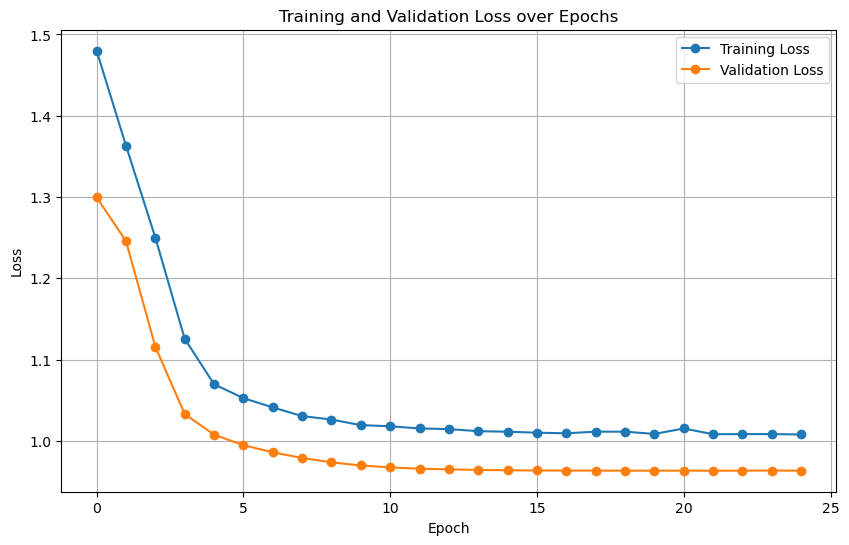

In [11]:
import matplotlib.pyplot as plt

# Assume 'df_logs' is your DataFrame with the logs
# Drop the rows with NaN values for plotting each loss curve separately
df_logs = pd.read_csv("lightning_logs/m1_vae/version_0/metrics.csv")

# Extract relevant columns
epochs = df_logs['epoch'].unique()  # Get unique epoch values
train_loss = df_logs['train_loss'].dropna()  # Drop NaN values for train loss
val_loss = df_logs['val_loss'].dropna()      # Drop NaN values for validation loss

# Plot the losses
plt.figure(figsize=(10, 6))

plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss', marker='o')
plt.plot(epochs[:len(val_loss)], val_loss, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
import yaml

# Load the hyperparameters from the hparams.yaml file
hparams_path = 'lightning_logs/m1_vae/version_0/hparams.yaml'  # Replace with the correct path
with open(hparams_path) as file:
    hparams = yaml.safe_load(file)

print(hparams)  # To inspect the hyperparameters


{'dropout_rate': 0.2, 'hidden_dims': [2048, 1024, 512], 'input_dim': 451747, 'latent_dim': 256, 'lr': 1e-06}


In [16]:
from pytorch_lightning import Trainer

checkpoint_path = "lightning_logs/m1_vae/version_0/checkpoints/m1-vae-epoch=21-val_loss=0.96.ckpt"
vae_model = VAE_Lightning.load_from_checkpoint(
    checkpoint_path,
    map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    **hparams
    )

vae_model.eval()

VAE_Lightning(
  (model): VAE(
    (encoder_layers): Sequential(
      (0): Linear(in_features=451747, out_features=2048, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=2048, out_features=1024, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=1024, out_features=512, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.2, inplace=False)
    )
    (fc_mu): Linear(in_features=512, out_features=256, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=256, bias=True)
    (decoder_layers): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=512, out_features=1024, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=1024, out_features=2048, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.2, inplace=False)
    )
    (

In [92]:
def get_latent_embeddings(model, dataloader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            x,y = batch

            x = x.to(device)
            y = y.to(device)
            
            # Replace NaNs with zero or another neutral value for forward pass
            x_filled = replace_nan_with_mean(x)
            # x_filled = torch.nan_to_num(x, nan=0.0)
            
            z, _, _ = model.forward(x_filled)
            embeddings.append(z)
            labels.append(y)
        
        embeddings = torch.cat(embeddings, dim=0)
        labels = torch.cat(labels, dim=0)

    return embeddings, labels

train_embeddings, train_labels = get_latent_embeddings(vae_model, train_loader)
val_embeddings, val_labels = get_latent_embeddings(vae_model, val_loader)
test_embeddings, test_labels = get_latent_embeddings(vae_model, test_loader)

        

In [93]:
# import umap
# import matplotlib.pyplot as plt
# import numpy as np

# # Combine train and validation embeddings
# combined_embeddings = torch.cat([train_embeddings, val_embeddings], dim=0).cpu().numpy()
# combined_labels = torch.cat([train_labels, val_labels], dim=0).cpu().numpy()
# # Convert one-hot encoded labels to class indices using argmax
# combined_labels_1d = combined_labels.argmax(axis=1)  # Find the index of the maximum (1) in each one-hot vector

# # Fit UMAP on the combined embeddings
# umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
# combined_umap = umap_model.fit_transform(combined_embeddings)

# # Plot UMAP embeddings (train + validation)
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(combined_umap[:, 0], combined_umap[:, 1], c=combined_labels_1d, cmap='Spectral', s=10, alpha=0.8)
# plt.colorbar(scatter)
# plt.title('UMAP Projection of Train + Validation Embeddings')
# plt.show()


In [94]:
# # Convert test one-hot encoded labels to class indices
# test_labels_1d = test_labels.cpu().numpy().argmax(axis=1)

# # Project test embeddings onto the UMAP space
# test_umap = umap_model.transform(test_embeddings.cpu().numpy())

# # Plot the test UMAP embeddings
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(test_umap[:, 0], test_umap[:, 1], c=test_labels_1d, cmap='Spectral', s=10, alpha=0.8)
# plt.colorbar(scatter)
# plt.title('UMAP Projection of Test Embeddings')
# plt.show()


# MLP building

In [162]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.optim import Adam

class MLP(pl.LightningModule):
    def __init__(self, input_dim, layer_dims, num_classes, dropout_rate=0.2, lr=1e-3, class_weights=None):
        """
        :param input_dim: Number of input features (e.g., from VAE embeddings)
        :param layer_dims: List of integers defining the number of units in each layer
        :param num_classes: Number of output classes for classification (should match the number of columns in one-hot labels)
        :param dropout_rate: Dropout rate to be applied after each layer
        :param lr: Learning rate
        """
        super(MLP, self).__init__()
        
        self.save_hyperparameters()  # Save hyperparameters for checkpointing

        # Store learning rate
        self.lr = lr
        # self.class_weights = class_weights  # Add class weights
        
        # Store the class weights and move them to the right device in the forward pass
        self.register_buffer('class_weights', class_weights)
        
        # Build the network layers
        layers = []
        current_dim = input_dim

        for dim in layer_dims:
            layers.append(nn.Linear(current_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_dim = dim

        # Output layer for one-hot encoded labels (num_classes)
        layers.append(nn.Linear(current_dim, num_classes))  # Output layer with num_classes
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch  # y is class index (not one-hot encoded)
        y_hat = self(x)
    
        # Use CrossEntropyLoss for single-label classification with class weighting
        loss = F.cross_entropy(y_hat, y, weight=self.class_weights.to(self.device))
        # loss = F.cross_entropy(y_hat, y)
    
        print(f"Training loss: {loss.item()}")
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch  # y is class index (not one-hot encoded)
        y_hat = self(x)
    
        val_loss = F.cross_entropy(y_hat, y, weight=self.class_weights.to(self.device))
        # val_loss = F.cross_entropy(y_hat, y)
    
        print(f"Validation loss: {val_loss.item()}")
        self.log('val_loss', val_loss, on_step=False, on_epoch=True)
        return val_loss
    
        
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)

In [163]:

labels_class = np.argmax(train_tensors[1], axis=1)  # Convert one-hot to class labels
labels_class = labels_class.numpy()

unique, counts = np.unique(labels_class, return_counts=True)
# unique, counts = unique.tolist(), counts.tolist()
# Convert back to tensor if needed, or just print the results
value_counts = dict(zip(unique, counts))
class_counts = counts
class_counts

array([ 843,   80,  124,    6,  671,   35, 3766,   15,  100,   21,   78,
         85,   50,   73,   40,   28,   78,  168, 1030,   21,  185,   50,
          3,  503,   26,   45,   61])

In [164]:
import torch
from torch.utils.data import WeightedRandomSampler

# Assume you have a tensor of class frequencies
# class_counts = torch.tensor([181, 17, 27, 1, 144, 7, 807, 3, 22, 4, 17, 19, 11, 16, 8, 6, 17, 36, 221, 4, 40, 10, 1, 108, 5, 10, 13])  # example
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()  # Normalize weights
class_weights = torch.tensor(class_weights).to(torch.float32)

class_weights


tensor([1.2265e-03, 1.2924e-02, 8.3380e-03, 1.7232e-01, 1.5409e-03, 2.9540e-02,
        2.7454e-04, 6.8928e-02, 1.0339e-02, 4.9234e-02, 1.3255e-02, 1.2164e-02,
        2.0678e-02, 1.4163e-02, 2.5848e-02, 3.6926e-02, 1.3255e-02, 6.1543e-03,
        1.0038e-03, 4.9234e-02, 5.5887e-03, 2.0678e-02, 3.4464e-01, 2.0555e-03,
        3.9766e-02, 2.2976e-02, 1.6949e-02])

## Train MLP

In [165]:
from torch.utils.data import DataLoader, WeightedRandomSampler

# Convert one-hot encoded labels to class indices
targets = torch.argmax(train_labels, dim=1)  # 'targets' contains class indices

# Count how many samples belong to each class
class_sample_count = torch.bincount(targets)  # Class counts for each class in targets

# Compute weights for each class
weights = torch.sqrt(1.0 / class_sample_count.float())  # Inverse of class frequency

# Assign weights to each sample based on its class
samples_weight = torch.tensor([weights[t] for t in targets])

# Define a WeightedRandomSampler with the computed sample weights
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# # Create DataLoader with the sampler
# train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)


In [168]:
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning import Trainer, loggers
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Assuming train_embeddings, val_embeddings, test_embeddings are the VAE embeddings
# and train_labels, val_labels, test_labels are one-hot encoded (not converting them back to class indices)

# # Create TensorDatasets
# train_dataset = TensorDataset(train_embeddings, train_labels)
# val_dataset = TensorDataset(val_embeddings, val_labels)
# test_dataset = TensorDataset(test_embeddings, test_labels)

# Convert one-hot encoded labels to class indices using argmax
train_labels_indices = torch.argmax(train_labels, dim=1)
val_labels_indices = torch.argmax(val_labels, dim=1)
test_labels_indices = torch.argmax(test_labels, dim=1)

# Now, use the class indices labels instead of one-hot encoded labels in your dataset
train_dataset = TensorDataset(train_embeddings, train_labels_indices)
val_dataset = TensorDataset(val_embeddings, val_labels_indices)
test_dataset = TensorDataset(test_embeddings, test_labels_indices)




# Create DataLoaders
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, worker_init_fn=lambda _: np.random.seed(42))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))

pl.seed_everything(42)

# Create a logger
logger = loggers.CSVLogger('lightning_logs/', name='m1_mlp')


# Define MLP layer dimensions
layer_dims = [64, 32]  # Example of multiple hidden layers
dropout_rate=0.6
lr=1e-4

# Initialize the MLP model with dropout
mlp_model = MLP(input_dim=train_embeddings.shape[1],  # Input dimension should match VAE embeddings size
                layer_dims=layer_dims, 
                num_classes=train_labels.shape[1],  # Number of output classes (same as number of columns in one-hot encoded labels)
                dropout_rate=dropout_rate, 
                lr=lr,
                class_weights=class_weights)

# Create the loss history callback
loss_history_callback = LossHistoryCallback()
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    dirpath=f'{logger.save_dir}/{logger.name}/version_{logger.version}/checkpoints/',
    filename='m1-mlp-{epoch:02d}-{val_loss:.2f}'
    )

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Initialize PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=200,
    callbacks=[checkpoint_callback, early_stopping_callback, loss_history_callback],
    accelerator='gpu',
    precision=32,
    devices=1 if torch.cuda.is_available() else 'auto',
    deterministic=True,  # Ensure reproducibility
    logger=logger,
    )

# Train the MLP model
trainer.fit(mlp_model, train_loader, val_loader)


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 19.4 K | train
---------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 128/128 [00:00<00:00, 158.33it/s, v_num=20]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/28 [00:00<?, ?it/s]Validation loss: 3.270726203918457

Validation DataLoader 0:   4%|▎         | 1/28 [00:00<00:00, 143.11it/s]Validation loss: 3.2547619342803955

Validation DataLoader 0:   7%|▋         | 2/28 [00:00<00:00, 174.09it/s]Validation loss: 3.389413833618164

Validation DataLoader 0:  11%|█         | 3/28 [00:00<00:00, 181.16it/s]Validation loss: 3.359450340270996

Validation DataLoader 0:  14%|█▍        | 4/28 [00:00<00:00, 189.71it/s]Validation loss: 3.2584776878356934

Validation DataLoader 0:  18%|█▊        | 5/28 [00:00<00:00, 191.30it/s]Validation loss: 3.347144603729248

Validation DataLoader 0:  21%|██▏       | 6/28 [00:00<00:00, 195.79it/s]Validation loss: 3.266162633895874

Validation DataLoader 0:  25%|██▌       | 7/28 [00:00<00:00, 199.16it/s]Validation loss: 3.303565740585327

Validation DataLoader 0:  2

In [ ]:
import matplotlib.pyplot as plt

# Assume 'df_logs' is your DataFrame with the logs
# Drop the rows with NaN values for plotting each loss curve separately
df_logs = pd.read_csv("lightning_logs/v2_m1_vae_5000/")

# Extract relevant columns
epochs = df_logs['epoch'].unique()  # Get unique epoch values
train_loss = df_logs['train_loss'].dropna()  # Drop NaN values for train loss
val_loss = df_logs['val_loss'].dropna()      # Drop NaN values for validation loss

# Plot the losses
plt.figure(figsize=(10, 6))

plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss', marker='o')
plt.plot(epochs[:len(val_loss)], val_loss, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [147]:
import torch

# Get predictions from the MLP model
def get_predictions(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    model.to(device)  # Move model to the correct device (e.g., GPU)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            x, labels = batch
            
            # Move data to the same device as the model
            x = x.to(device)
            labels = labels.to(device)
            
            # Get logits from the model
            logits = model(x)
            
            # Get predicted classes
            preds = torch.argmax(logits, dim=1)
            
            # Append predictions and labels
            all_preds.append(preds.cpu())  # Move predictions back to CPU
            all_labels.append(labels.cpu())  # Move labels back to CPU

    # Concatenate all predictions and labels
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    return all_preds, all_labels

# Define the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get predictions and labels on the test set
test_preds, labels_test = get_predictions(mlp_model, test_loader, device)


In [148]:
# import yaml

# # Load the hyperparameters from the hparams.yaml file
# hparams_path = 'lightning_logs/m1_mlp/'  # Replace with the correct path
# with open(hparams_path) as file:
#     hparams = yaml.safe_load(file)

# print(hparams)  # To inspect the hyperparameters
# from pytorch_lightning import Trainer

# checkpoint_path = "lightning_logs/m1_vae/version_0/checkpoints/m1-vae-epoch=21-val_loss=0.96.ckpt"
# vae_model = VAE_Lightning.load_from_checkpoint(
#     checkpoint_path,
#     map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
#     **hparams
#     )

# vae_model.eval()

In [149]:
import numpy as np
from sklearn.metrics import classification_report

# Convert one-hot encoded labels back to class indices
# test_labels_argmax = np.argmax(test_labels, axis=1)

# Generate class names for 27 classes
target_names = [f"Class {i}" for i in range(27)]

# Generate the classification report using class labels
report = classification_report(labels_test, test_preds, target_names=target_names, zero_division=0)


# Print the report
print(report)


              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       181
     Class 1       0.01      0.76      0.02        17
     Class 2       0.00      0.00      0.00        27
     Class 3       0.00      0.00      0.00         1
     Class 4       0.00      0.00      0.00       144
     Class 5       0.00      0.00      0.00         7
     Class 6       0.00      0.00      0.00       807
     Class 7       0.00      0.00      0.00         3
     Class 8       0.00      0.00      0.00        22
     Class 9       0.00      0.00      0.00         4
    Class 10       0.00      0.00      0.00        17
    Class 11       0.00      0.00      0.00        19
    Class 12       0.00      0.00      0.00        11
    Class 13       0.00      0.00      0.00        16
    Class 14       0.00      0.00      0.00         8
    Class 15       0.00      0.00      0.00         6
    Class 16       0.00      0.00      0.00        17
    Class 17       0.00    

In [33]:
train_loader

In [57]:
train_dataset

In [69]:
train_labels

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [70]:
val_labels

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [71]:
test_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)